# Quantum Phase Estimation

In [2]:
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_bloch_multivector
from qiskit.primitives import BackendSampler
from qiskit.quantum_info import SparsePauliOp, Statevector, Pauli
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import UnitaryGate

from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import expm

from qiskit.circuit.library import QFT
# from qiskit_aer import AerSimulator, StatevectorSimulator
# from qiskit_ibm_provider import IBMProvider
# aer_sim = AerSimulator()
# aer_sim = StatevectorSimulator()
# backend = aer_sim
# backend = quantum_hardware
# qc_trans = transpile(circuit, backend, initial_layout=layout, optimization_level=2)

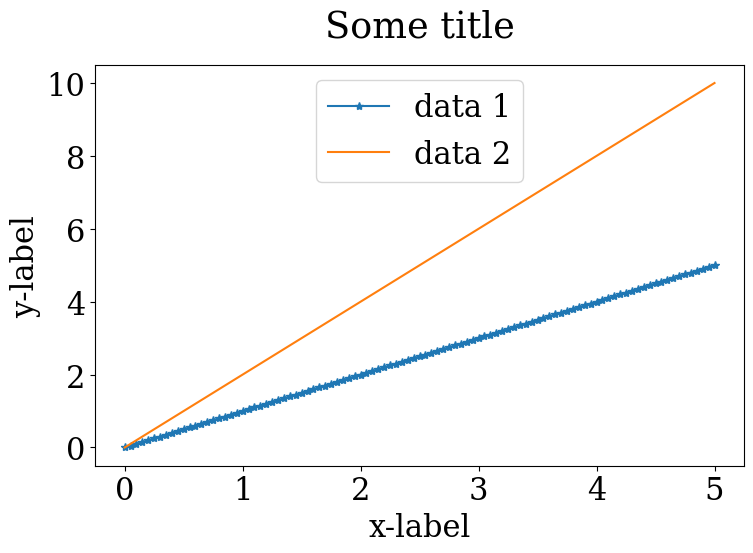

In [3]:
 
import numpy as np
import matplotlib.pyplot as plt


if __name__ == "__main__":

    plt.rcParams["font.family"] = "serif"
    plt.rcParams["mathtext.fontset"] = "dejavuserif"

    # NOTE I usually make plots 0.5*\textwidth; this font size is legible 
    plt.rcParams.update({"font.size": 22})

    resolution = 150

    x_data = np.linspace(0, 5, num=101)
    y_data1 = x_data
    y_data2 = 2 * x_data

    fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))

    ax1.plot(x_data, y_data1, "-*", label="data 1")
    ax1.plot(x_data, y_data2, "-", label="data 2")

    # ax1.set_yscale('log')
    # ax1.set_xscale('log')
    # ax1.set_ylim([0.,2])

    ax1.legend(loc="upper center")
    ax1.set_title("Some title", pad=20)
    ax1.set_xlabel("x-label")
    ax1.set_ylabel("y-label")

    fig.tight_layout()
    fig.savefig(
        "",
        bbox_inches="tight",
        dpi=resolution,
        transparent=True,
        facecolor="w",
        edgecolor="w",
        orientation="landscape",
    )

    plt.show()

## Objective

The quantum phase estimation algorithm (QPE) is very key for many quantum algorithms. It's goal is to find the eigenvalue of some given eigenstate of a unitary operator. In this problem we are given two things: a unitary operator $U$ and one of its eigenvalues $|\psi\rangle$. As we have previously discussed, because it is a unitary operator, we can write

$$U|\psi\rangle = e^{2\pi i\varphi}|\psi\rangle$$

where $0\leq\varphi<1$. Our goal is to estimate the eigenvalue and thus the phase $\varphi$ of $|\psi\rangle$. Just like with the Hadamard test, the phase of $U$ is written onto our control qubits. But because this is in the Fourier basis, we apply the inverse $\text{QFT}$ to transform it to the computational basis to perform a measurement. Recall from the $\text{QFT}$ section that in the Fourier basis the topmost qubit completes one rotation when counting from $0$ to $2^n$ where $n$ is the number of control qubits. For example, to count to some number $x$ between $0$ and $2^n$, the rotation of the first three qubits $R_{q_{n}}$ around the $z$-axis is as follows:

$$R_{q_0} = \frac{x}{2^n} \qquad R_{q_1} = \frac{2x}{2^n} \qquad R_{q_2} = \frac{4x}{2^n}$$

When performing a controlled-$U$ operation, as we mentioned before, the qubit will proportionally rotate to the phase $e^{2\pi i \varphi}$. In order to correctly encode the phase $\varphi$ (a number between $0$ and $2^n$), we can apply $C-U$ gates in succession to repeat this rotation a number of times until the phase $\varphi$ has been applied in the Fourier basis. Then by using the inverse $\text{QFT}$ we transform it to the computational basis for measurement.  

## Proof

Let's walk through the math of this procedure and how it is implemented as a circuit. We start with some state $|\psi\rangle$ as one set of qubit registers and $n$ counting qubits making up the counting register. Since all of our qubits start in the state $|0\rangle$, we can represent the initial state of our circuit as

$$|\psi_0\rangle = |0\rangle^{\otimes n}|\psi\rangle$$

To put each counting qubit into superposition we then apply a Hadamard gate to all $n$ qubits putting our circuit in the state

$$|\psi_1\rangle = \frac{1}{\sqrt{2^n}}(|0\rangle + |1\rangle)^{\otimes n}|\psi\rangle$$

We then apply our $C-U$ gates. Since we already know that $U|\psi\rangle = e^{2\pi i\varphi}|\psi\rangle$, when applying this gate to all $n$ qubits, it then follows that 

$$U^{2^j}|\psi\rangle = U^{2^{j}-1}U|\psi\rangle = U^{2^{j}-1}e^{2\pi i \varphi}|\psi\rangle = U^{2^{j}-2}e^{4\pi i \varphi}|\psi\rangle = \dots = e^{2\pi i 2^j \varphi}|\psi\rangle$$

Therefore, by controlling this gate and applying it to all $n$ qubits so it only affects the state for the case in which it is $|1\rangle$, we apply $C-U^{2^j}$ where $0 \leq j \leq n-1$ leaving us with

$$|\psi_2\rangle = \frac{1}{\sqrt{2^n}}\left(|0\rangle + e^{2\pi i \varphi 2^{n-1}}|1\rangle\right)\otimes \left(|0\rangle + e^{2\pi i \varphi 2^{n-2}}|1\rangle\right) \otimes \dots \otimes \left(|0\rangle + e^{2\pi i \varphi 2^{0}}|1\rangle\right)\otimes|\psi\rangle= \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1}e^{2\pi i \varphi k}|k\rangle|\psi\rangle$$

Here, $k$ is the integer representation of $n$-bit binary numbers. Looking at this expression it is clearly visible that this is the same as applying the $\text{QFT}$ to the state $|\psi\rangle$. Recall that the transform $\text{QFT}_N$ where $N=2^n$ maps some $n$-qubit state $|x\rangle$ into the output state

$$\text{QFT}_N|x\rangle = \frac{1}{\sqrt{N}}\left(|0\rangle + e^{\frac{2\pi ix}{2}}|1\rangle\right)\otimes\left(|0\rangle + e^{\frac{2\pi ix}{2^2}}|1\rangle\right)\otimes\dots\otimes\left(|0\rangle + e^{\frac{2\pi ix}{2^{n-1}}}|1\rangle\right)\otimes\left(|0\rangle + e^{\frac{2\pi ix}{2^n}}|1\rangle\right)$$

By then replacing $x$ with $2^n\varphi$ in the above expression, we see that this gives the exact same expression as $|\psi_2\rangle$. Therefore, in order to recover the state $|2^n\varphi\rangle$, the inverse $\text{QFT}$ is applied giving

$$|\psi_3\rangle = \frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1}e^{2\pi i \varphi k}|k\rangle|\psi\rangle \xrightarrow{\text{QFT}_N^\dagger} \frac{1}{2^n}\sum_{x=0}^{2^n-1}\sum_{k=0}^{2^n-1}e^{-\frac{2\pi i k}{2^n}(x-2^n\varphi)}|x\rangle|\psi\rangle$$

Looking at the exponent in this expression, we can see that the function peaks near $x = 2^n\varphi$ which is what we want.

## Verification

### Single Qubit QPE

QPE is very similar to QFT

In [21]:
def add_inv_fourier_transform(circuit, qubits, show_steps = False):
    circuit.barrier()
    for i in range(int(qubits/2)):
        circuit.swap(i, qubits-i-1)
    for highest in range(qubits):
        if show_steps: print("\nPreforming inverse transform on qubit", highest)
        circuit.barrier()
        for qubit in range(highest):
            # qubit = highest-j-1
            if show_steps: print("\tControl Phase -π/2^"+str(highest-qubit)+" gate applied to", highest, "using qubit", qubit, "as control")
            circuit.cp(-pi/2**(highest-qubit), highest, qubit)
        if show_steps: print("\tAdding H gate to qubit", highest)
        circuit.h(highest) 
    if show_steps: print("\nCompleted transformation\n")

def setup(circuit, ancilla_bits):
    for i in range(ancilla_bits):
        circuit.h(i)

def measure(circuit, ancilla_bits):
    for i in range(ancilla_bits):
        qc.measure(i,i)

In [22]:
ancilla_bits = 4
angle = .25

In [23]:
print("Decimal Representation of the phase angle:", angle)
reading_angle = angle
print("Binary Representation of the phase angle:  0.", end="")
for i in range(1,ancilla_bits+1):
    if reading_angle - 1/2**i >= 0:
        reading_angle -= 1/2**i
        print("1", end="")
    else:
        print("0", end="")
print()

Decimal Representation of the phase angle: 0.25
Binary Representation of the phase angle:  0.0100


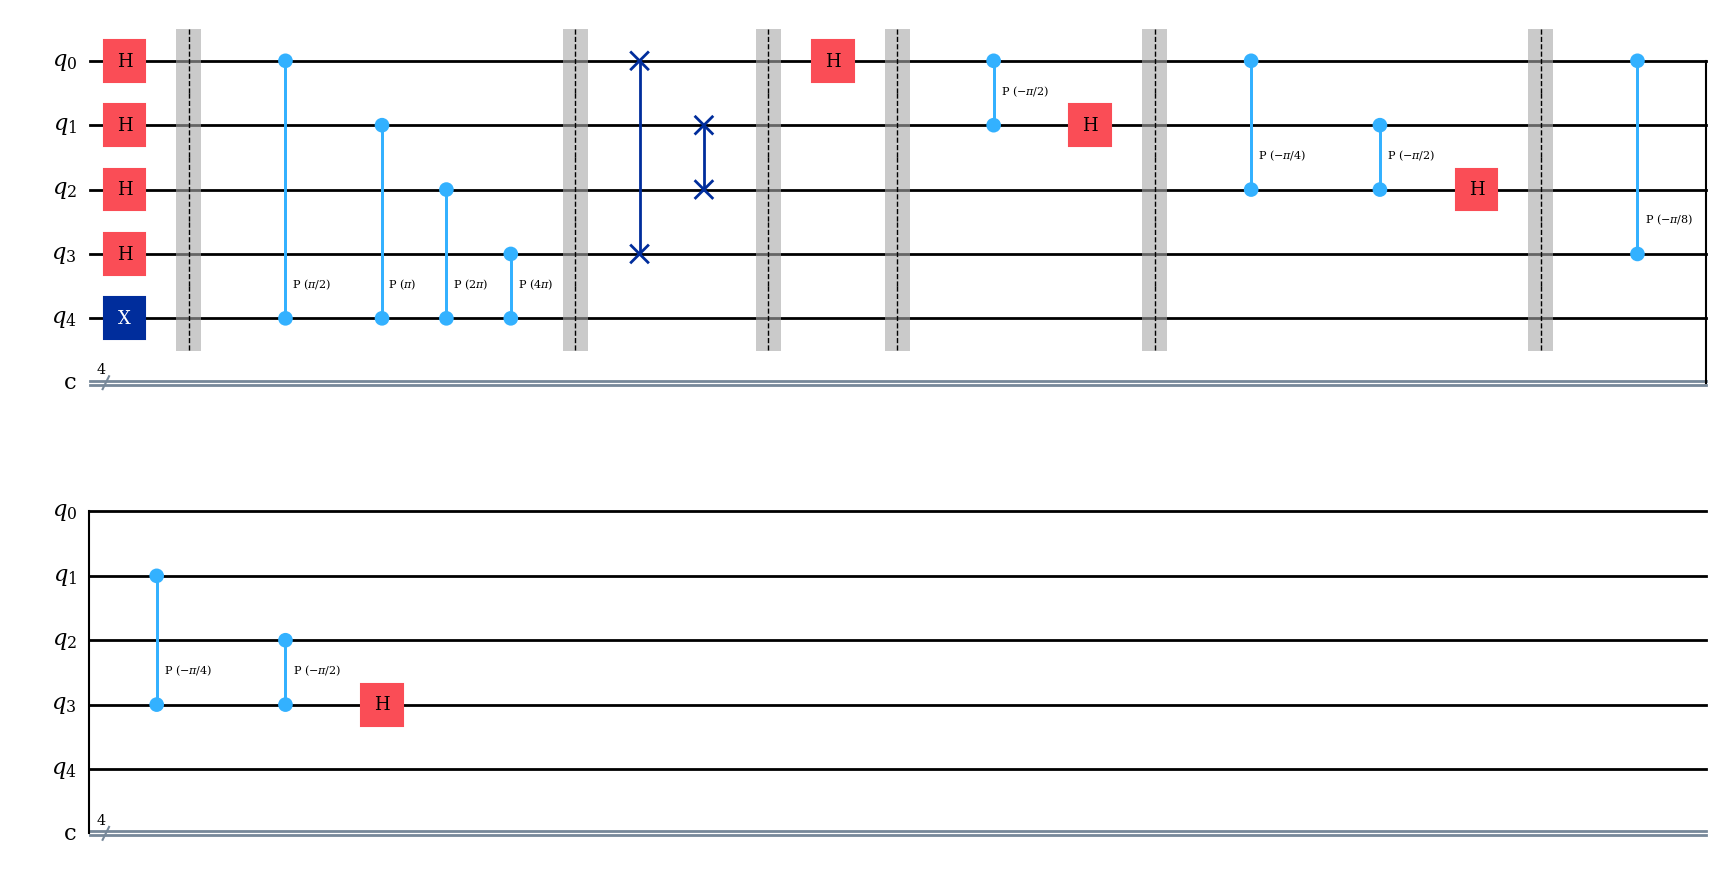

In [24]:
qc = QuantumCircuit(ancilla_bits+1, ancilla_bits)
setup(qc, ancilla_bits)
qc.x(ancilla_bits)
qc.barrier()
for i in range(ancilla_bits):
    qc.cp((2*pi*angle)*2**(i), ancilla_bits,i)

add_inv_fourier_transform(qc,ancilla_bits)

# qc.append(QFT(ancilla_bits).inverse(), ancilla_bits)
qc.compose(QFT(ancilla_bits, inverse = True), range(ancilla_bits))
qc.draw('mpl')

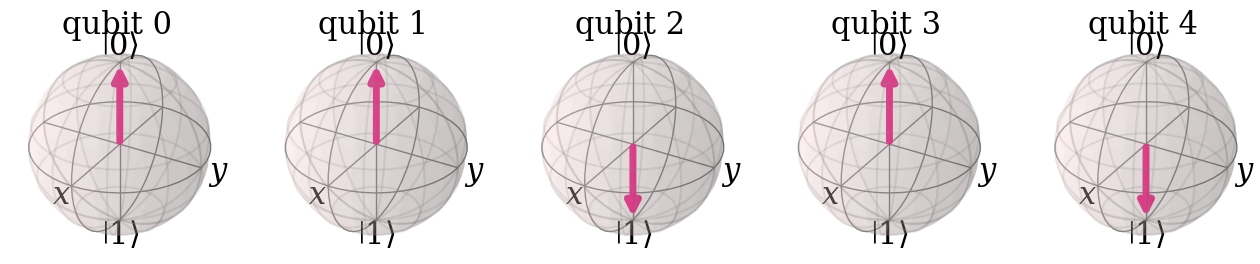

In [25]:
sv = Statevector(qc)
plot_bloch_multivector(sv)

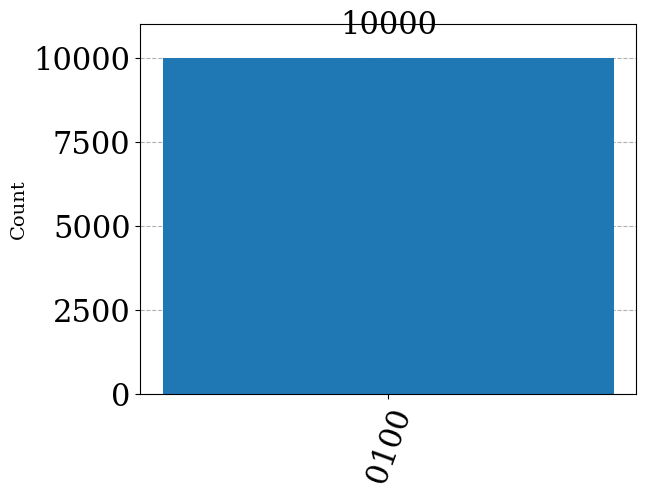

In [16]:
measure(qc, ancilla_bits)
backend = BasicSimulator()
result = backend.run(qc, shots=10000).result()   
counts = result.get_counts()                    
plot_histogram(counts)


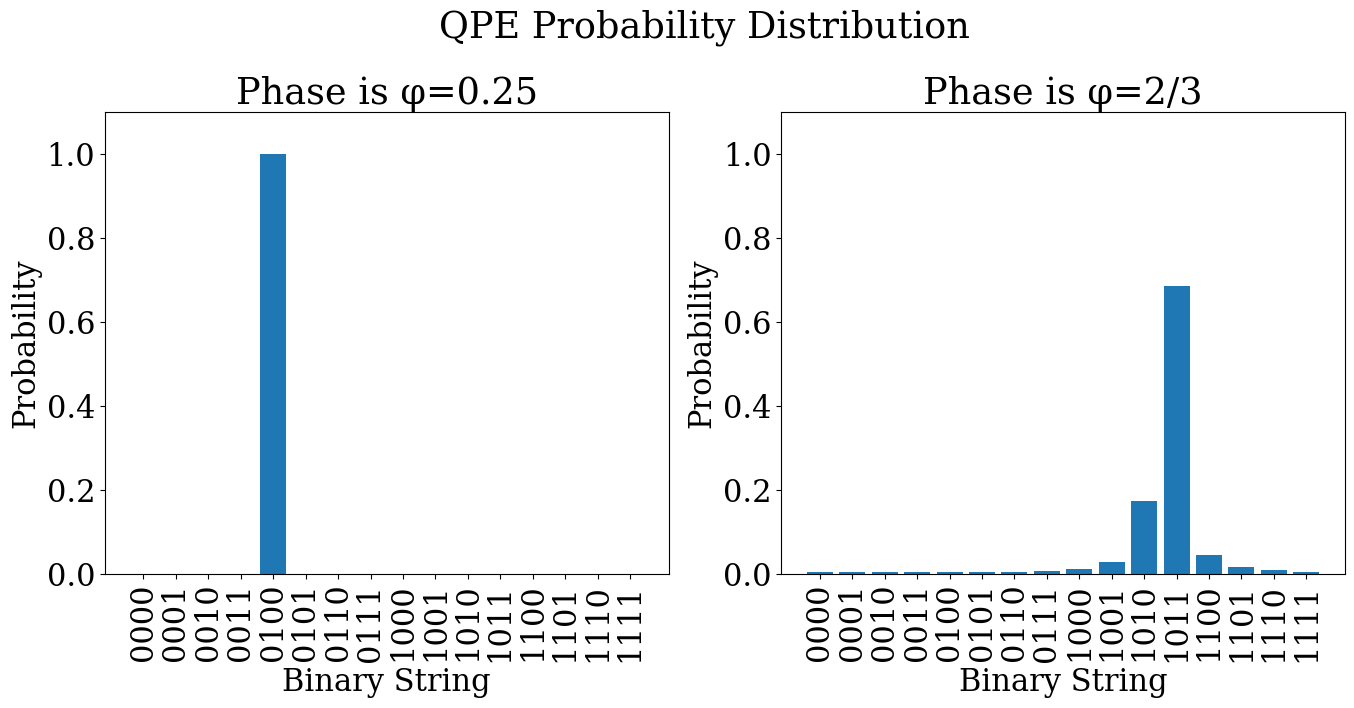

In [71]:
ancilla_bits = 4
fig,axs = plt.subplots(1,2, figsize=(16, 6))
plt.suptitle("QPE Probability Distribution", x=.5, y=1.05)

angle = .25
qc = QuantumCircuit(ancilla_bits+1, ancilla_bits)
setup(qc, ancilla_bits)
qc.x(ancilla_bits)
qc.barrier()
for i in range(ancilla_bits):
    qc.cp((2*pi*angle)*2**(i), ancilla_bits,i)

add_inv_fourier_transform(qc,ancilla_bits)

# qc.append(QFT(ancilla_bits).inverse(), ancilla_bits)
qc.compose(QFT(ancilla_bits, inverse = True), range(ancilla_bits))
qc.draw('mpl')

ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()
new_dist = {}
for key in ideal_distribution:
    bin_num = key[1:]
    try:
        new_dist[bin_num] += ideal_distribution[key]
    except:
        new_dist[bin_num] = ideal_distribution[key]

plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=90)
axs[0].set_ylabel("Probability")
axs[0].set_xlabel("Binary String")
axs[0].set_title("Phase is φ=0.25")
axs[0].set_ylim([0,1.1])
bar = axs[0].bar(new_dist.keys(), new_dist.values())

angle = 2/3
qc = QuantumCircuit(ancilla_bits+1, ancilla_bits)
setup(qc, ancilla_bits)
qc.x(ancilla_bits)
qc.barrier()
for i in range(ancilla_bits):
    qc.cp((2*pi*angle)*2**(i), ancilla_bits,i)

add_inv_fourier_transform(qc,ancilla_bits)

# qc.append(QFT(ancilla_bits).inverse(), ancilla_bits)
qc.compose(QFT(ancilla_bits, inverse = True), range(ancilla_bits))
qc.draw('mpl')

ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()
new_dist = {}
for key in ideal_distribution:
    bin_num = key[1:]
    try:
        new_dist[bin_num] += ideal_distribution[key]
    except:
        new_dist[bin_num] = ideal_distribution[key]

plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[1].set_ylabel("Probability")
axs[1].set_xlabel("Binary String")
axs[1].set_title("Phase is φ=2/3")
axs[1].set_ylim([0,1.1])
bar = axs[1].bar(new_dist.keys(), new_dist.values())
plt.show()

In [9]:
binary_num = ''
max_num = 0
for key in counts:
    if (counts[key] > max_num):
        max_num = counts[key]
        binary_num = key
print("Binary Number with Maximum count:     0."+binary_num)
decimal_num = 0
for i in range(len(binary_num)):
    decimal_num += int(binary_num[i])/2**(i+1)
print("Decimal Number with Equivalent Value:",decimal_num)

Binary Number with Maximum count:     0.01011
Decimal Number with Equivalent Value: 0.34375


### Using QPE to check the Phase of a Matrix

#### Unitary Matrix

The process for checking the phase of matrix is very similar to checking the phase of a single qubit, just with more input qubits. The phase of multiple bits is how far the qubits's probabilies rotated in the complex plane. As a reminder this phase shift is an eigenvalue of the inputted statevector.

Not all eigenvalues are valued the same. For a lot applications of QPE, the only important eigenvalue is the lowest one, which usually represents the lowest energy state of a system. The matrix used to represent this system is called a Hamiltonian. This lowest energy state is called the ground state.

We can pretend each element in the matrix represents a number of revolutions. Paricles that rotate more represent having more energy, and particles that rotate less would have less energy. We can differencate different energy states by measuring the total phase shift in the statevector.

For simple and small matrices, it is easy to test many different eigenvectors to determine the ground state of a system.

In [10]:
ancilla_bits = 6

In [11]:
eigen_bits = 2
H = np.asarray([[.25,0,0,0],
                [0,.3,0,0],
                [0,0,.4,0],
                [0,0,0,.5]], complex)

print("Hamiltonian:\n", H)

print("\nEigenvalues of the Hamiltonian:\n", np.linalg.eigvals(H))
min_eigenvalue = np.min(np.linalg.eigvals(H))
print("\nLowest energy Eigenvalue", min_eigenvalue)

# convert revolutions to radians
H *= 2*np.pi*1j

# convert the rotations to complex numbers
H = expm(H)

Hamiltonian:
 [[0.25+0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.3 +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.4 +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.5 +0.j]]

Eigenvalues of the Hamiltonian:
 [0.25+0.j 0.3 +0.j 0.4 +0.j 0.5 +0.j]

Lowest energy Eigenvalue (0.25+0j)


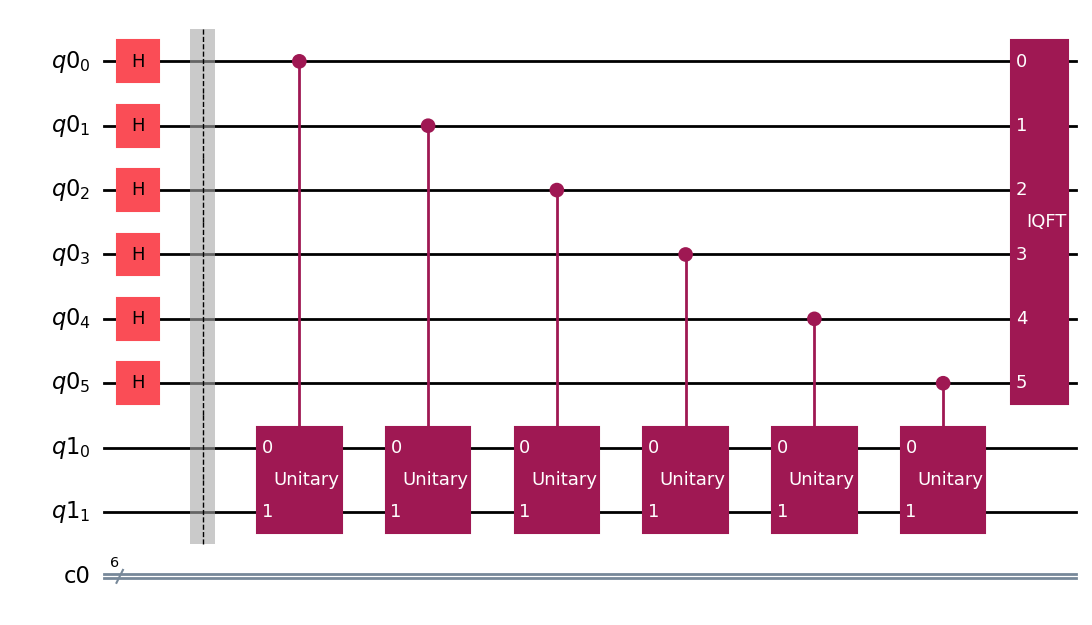

In [12]:
qr_ancilla = QuantumRegister(ancilla_bits)
qr_eigenstate = QuantumRegister(eigen_bits)
cr = ClassicalRegister(ancilla_bits)
qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)

# prepare state
qc.h(qr_ancilla)


# Modify the input state here
# qc.x(6)
# qc.x(7)


qc.barrier()

for i in range(ancilla_bits):
    mat = np.linalg.matrix_power(H, 2**(i))
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[i]] + qr_eigenstate[:] )

qc.append(QFT(ancilla_bits).inverse(), qr_ancilla)
# measure(qc, ancilla_bits)
qc.draw('mpl')

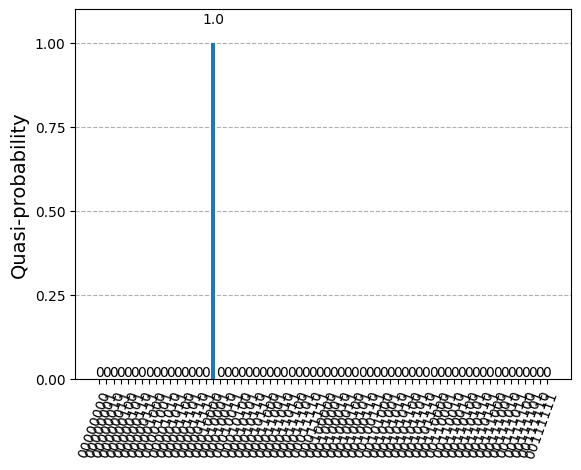

In [13]:
ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()
plot_histogram(ideal_distribution)

In [14]:
max_num = 0
binary_num = ''
for key in ideal_distribution:
    if (ideal_distribution[key] > max_num):
        max_num = ideal_distribution[key]
        binary_num = key
        
binary_num = binary_num[eigen_bits:]

decimal_num = int(binary_num, 2) / (2 ** (ancilla_bits))

print("Lowest energy Eigenvalue", min_eigenvalue.real)
print("Binary Number Output: 0."+str(binary_num))
print("Decimal Number with Equivalent Value:",decimal_num)

Lowest energy Eigenvalue 0.25
Binary Number Output: 0.010000
Decimal Number with Equivalent Value: 0.25


Suppose the matrix is large enough where we cannot guess every single possible combinatation of states. We can use superposition to test every since combination of states at the same time, since a particle in superposition is in both its states at the same time. That means if the statevector is in superpostion of the basis of the matrix, all possible states are tested as the same time. Since the ground state is the lowest possible energy of a given system, it is more stable than the other energy states, which means it is more likely to come up.

In [15]:
ancilla_bits = 6

In [16]:
eigen_bits = 2
H = np.asarray([[.9,0,0,0],
                [0,.49,0,0],
                [0,0,.9,0],
                [0,0,0,.9]], complex)

print("Hamiltonian:\n", H)

print("\nEigenvalues of the Hamiltonian:\n", np.linalg.eigvals(H))
min_eigenvalue = np.min(np.linalg.eigvals(H))
print("\nLowest energy Eigenvalue", min_eigenvalue)

# convert revolutions to radians
H *= 2*np.pi*1j

# convert the rotations to complex numbers
H = expm(H)

Hamiltonian:
 [[0.9 +0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.49+0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.9 +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.9 +0.j]]

Eigenvalues of the Hamiltonian:
 [0.9 +0.j 0.49+0.j 0.9 +0.j 0.9 +0.j]

Lowest energy Eigenvalue (0.49+0j)


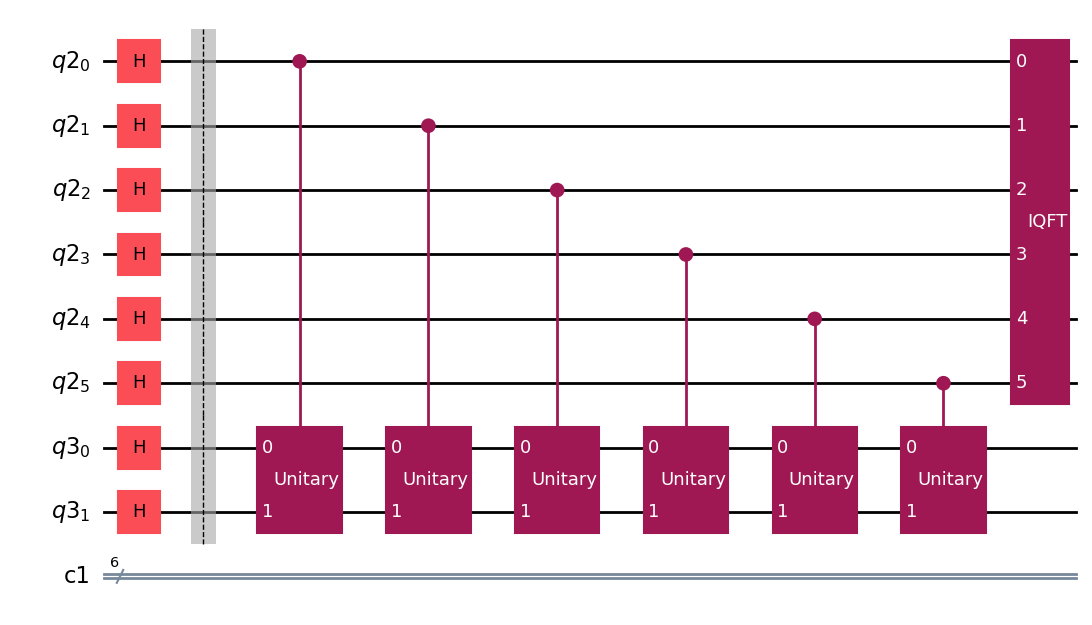

In [17]:
qr_ancilla = QuantumRegister(ancilla_bits)
qr_eigenstate = QuantumRegister(eigen_bits)
cr = ClassicalRegister(ancilla_bits)
qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)

# prepare state
qc.h(qr_ancilla)
qc.h(qr_eigenstate)

qc.barrier()

for i in range(ancilla_bits):
    mat = np.linalg.matrix_power(H, 2**(i))
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[i]] + qr_eigenstate[:] )

# for i in range(int(ancilla_bits/2)):
#     qc.swap(i, ancilla_bits-i-1)

qc.append(QFT(ancilla_bits).inverse(), qr_ancilla)
# measure(qc, ancilla_bits)
qc.draw('mpl')

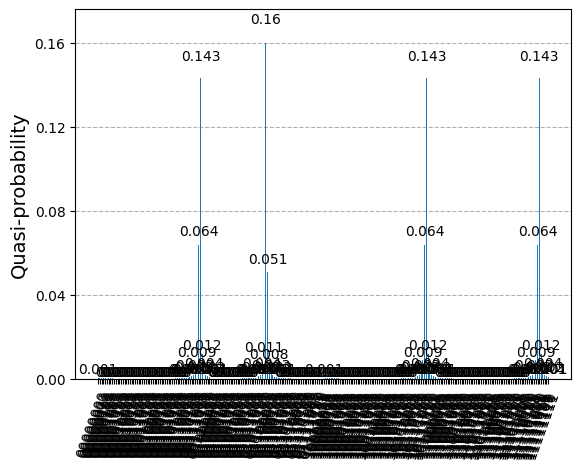

In [18]:
ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()
plot_histogram(ideal_distribution)

In [19]:
max_num = 0
binary_num = ''
for key in ideal_distribution:
    if (ideal_distribution[key] > max_num):
        max_num = ideal_distribution[key]
        binary_num = key
        
binary_num = binary_num[eigen_bits:]

decimal_num = int(binary_num, 2) / (2 ** (ancilla_bits))

print("Lowest energy Eigenvalue", min_eigenvalue.real)
print("Binary Number Output: 0."+str(binary_num))
print("Decimal Number with Equivalent Value:",decimal_num)

Lowest energy Eigenvalue 0.49
Binary Number Output: 0.011111
Decimal Number with Equivalent Value: 0.484375


### Error Analysis

When applying the QPE method on a quantum computer, so far we have assumed that both $|\psi\rangle$ is an eigenstate and its phase $\varphi$ has some $d$-bit binary representation. In general, when practically applying this method neither of these conditions can be exactly satsified. To this end it is necessary to analyze this effect on the error of the QPE. So what happens when these conditions are not exactly met? First, as before we assume a unitary operator $U$ has the eigendecomposition 

$$U|\psi_j \rangle = e^{i2\pi \varphi_j}|\psi_j\rangle$$

We assume $0\leq \varphi_0 \leq \varphi_1 \dots \leq \varphi_{N-1}\leq 1$ where we are interested in using QPE to find the phase of the groundstate $\varphi_0$. 

In order to analyze the error, we first relax the first condition, meaning the second condition is assumed to be exactly true. This means that all $\varphi_i$'s have an exact $d$-bit binary representation, but the quantum state is given by some linear combination

$$|\phi\rangle = \sum_{k\in[N]}c_k|\psi_k\rangle$$

where the probability of the ground state is $p_0 = |\langle\phi|\psi_0\rangle|^2 = |c_0|^2 < 1$.

Then applying the QPE procedure to $t$ ancilla qubits and the quantum state $|\phi\rangle$ where $t=d$ because $\varphi$ is represented by a $d$-bit binary number (QPE applied to $|0^t\rangle|\phi\rangle$), measuring the ancilla qubits then returns the binary representation of $\varphi_0$ with probability $p_0$. The system register containing the quantum state also returns the eigenstate $|\psi_0\rangle$ with probability $p_0$. However, in order to realize that $\varphi_0$ is actually the desired phase, some sort of background knowledge of the location of $\varphi_0$ is necessary. For example we must know $\varphi_0 \in (\alpha, \beta)$ and $\varphi_i > \beta$ for all $i \neq 0$. It may then be desirable to relax both of the conditions, discussed above, but this requires a much more involved analysis and additional assumptions. 

To simplify this analysis, we will only consider the case in which the second condition is violated meaning $\varphi_0$ cannot be exactly represented by some binary $d$-bit number. In this case the QPE circuit is still applied to an initial state $|0^t\rangle|\phi\rangle$ but with $t>d$. Taking the converted estimated binary phase to base 10 as $\tilde{\varphi}_{k'} = \frac{k'}{2^t}$ where $k'$ is the binary representation of the phase and applying the QPE to this state gives

$$|0^t\rangle|\psi_0\rangle \xrightarrow{\text{QFT}} \frac{1}{\sqrt{2^t}}\sum_{j\in[2^t]}|j\rangle e^{i2\pi j\varphi_0}|\psi_0\rangle \xrightarrow{\text{QFT}^{\dagger}} \sum_{k'\in[2^t]}\left(\frac{1}{2^t}\sum_{j\in[2^t]}e^{i2\pi j \left(\varphi_0 - \frac{k'}{2^t}\right)}\right)|k'\rangle|\psi_0\rangle$$


Looking at this expression we can clearly see that this is exactly applying the forward followed by the inverse $\text{QFT}$ on the state. For simplicity, we say

$$|0^t\rangle|\psi_0\rangle \xrightarrow{\text{QPE}} \sum_{k'}\gamma_{0,k'}|k'\rangle|\psi_0\rangle \ , \quad \gamma_{0,k'} = \frac{1}{2^t}\sum_{j\in[2^t]}e^{i2\pi j \left(\varphi_0 - \frac{k'}{2^t}\right)}$$

Recall that a geometric series of the form $S = a + ar^2 + ar^3 + \dots + ar^n$ can be represented as the formula

$$S = \frac{a(r^n-1)}{r-1}$$

Recognizing that $\gamma_{0,k'}$ is a gemotric series with the common ratio $r = e^{i2\pi \left(\varphi_0 - \frac{k'}{2^t}\right)}$ and the coefficient $a = \frac{1}{2^t}$, this can be further simplified by

$$\gamma_{0,k'} = \frac{1}{2^t}\frac{1-r^{2^t}}{1-r} = \frac{1}{2^t}\frac{1-e^{i\pi 2^{t+1} \left(\varphi_0 - \tilde{\varphi}_{k'}\right)}}{1-e^{i2\pi \left(\varphi_0 - \tilde{\varphi}_{k'}\right)}}$$

From this expression we can tell that for the case in which $\varphi_0$ has an exact $d$-bit representation meaning $\varphi_0 = \tilde{\varphi}_{k_0'}$ for some $k_0'$, then $\gamma_{0,k'} = \delta_{k',k_0'}$ the Dirac delta function as shown in the plots below. This is to say that if there is an exact $d$-bit representation of the phase $\varphi_0$, one run of the QPE circuit will give the value $\varphi_0$ deterministically. Now assume that $\varphi_0 \neq \tilde{\varphi}_{k'}$ for any $k'$. Since $e^{i2\pi x}$ is a periodic function with a period of $1$, we can only find the value of $x \mod{1}$. Therefore, when estimating the phase $k_0'$ we are aiming for precision $\epsilon = \frac{1}{2^d} = \frac{2^{t-d}}{2^t}$ such that 

$$\left|\varphi_0-\tilde{\varphi}_{k_0'}\right|_1<\epsilon$$

Using the relationship that for any $\theta \in [-\pi,\pi]$

$$\left|1-e^{i\theta}\right| = \left|(1-\cos\theta)-i\sin\theta\right| = \sqrt{(1-\cos\theta)^2 + \sin\theta} = \sqrt{2(1-\cos\theta)} = 2\left|\sin\frac{\theta}{2}\right|\geq\frac{2}{\pi}\left|\theta\right|$$

and that

$$\left|1 - e^{i\theta}\right| \leq \left|1\right| + \left|e^{i\theta}\right| = \sqrt{1^2} + \sqrt{\cos^2\theta - (i\sin\theta)^2} = 1 + \sqrt{\cos^2\theta + \sin^2\theta} = 1 + 1 = 2$$

we find that 

$$\left|\gamma_{0,k'}\right| \leq \frac{2}{2^t2\pi\frac{2}{\pi}\left|\varphi_0 - \tilde{\varphi}_{k'}\right|_1} = \frac{1}{2^{t+1}\left|\varphi_0 -\tilde{\varphi}_{k'}\right|_1} $$

Now, we will plot $|\gamma_{0,k'}|$ against the phase $\varphi_{0,k'}$ for a couple different values of ancilla bits $t$. Using a phase of $\varphi_0=0.35$, we should see $|\gamma_{0,k'}|$ approach the Dirac delta function $\delta_{k',k_0'}$ at this value.

First, we set the phase to be estimated by the algorithm and convert it into its $t$-bit binary representation where $t$ is the number of ancilla bits. The quantum circuit circuit is then initizalized with $1$ more than the desired number of ancilla qubits. An $H$ gate is applied to all but $1$ of the qubits. These are the ancillas. The last qubit represents the quantum state $|\psi\rangle$ which is prepared with an $X$ gate. A for loop then applies all the $C-U$ operations targeted to the state $|\psi\rangle$ and controlled by each ancilla bit. Finally, the $\text{QFT}^{\dagger}$ function defined above is applied to the circuit, and every ancilla bit is measured. 

In [41]:
ancilla_bits = 6 # set number of ancilla qubits. change an rerun for other graph
angle = 0.35 # set phase. make sure to change plot truncation if phase is changed

In [42]:
print("Decimal Representation of the phase angle:", angle)
reading_angle = angle
print("Binary Representation of the phase angle:  0.", end="")
for i in range(1,ancilla_bits+1): # convert phase to binary for respective number of ancilla qubits
    if reading_angle - 1/2**i >= 0:
        reading_angle -= 1/2**i
        print("1", end="")
    else:
        print("0", end="")
print()

Decimal Representation of the phase angle: 0.35
Binary Representation of the phase angle:  0.010110


In [43]:
qc = QuantumCircuit(ancilla_bits+1, ancilla_bits)
setup(qc, ancilla_bits) # defined function that applies Hadamard gates to all ancillas
qc.x(ancilla_bits) # apply an X gate to the last qubit to prepare |psi>
qc.barrier()
for i in range(ancilla_bits): # apply controlled unitaries 
    qc.cp((2*pi*angle)*2**(i), ancilla_bits,i)

add_inv_fourier_transform(qc,ancilla_bits) # defined inverse QFT that applies the IQFT to the circuit 


#qc.compose(QFT(ancilla_bits, inverse = True), range(ancilla_bits))
#qc.draw('mpl')

Now that the circuit has been created, we will run it on a Qiskit backend to return the counts of each $t$-bit binary number. Then by looping through the binary numbers and converting them to base $10$ decimals, we can create an array of all of the possible values this circuit with $t$ ancillas can return. 

In this example, the circuit was ran with values of $t = 6$ and $t = 10$ ancillas for a phase of $\varphi_0 = 0.35$. Since this decimal does not have an exact bit binary representation, as the number of ancilla qubits increases, $|\gamma_{0,k'}|$ will approach $\delta_{k',k_0'}$.

In [44]:
measure(qc, ancilla_bits) # measure ancillas
backend = BasicSimulator() # set backend to simulator
result = backend.run(qc, shots=10000).result() # get backend results
counts = result.get_counts() # get counts of each binary phase from results               

kvals = []
binaries = []
for key in counts: # make a list of all binary possibilities
    binaries.append(key)
for num in binaries: # convert all binary numbers to decimals and make array
    decimal = 0
    for i in range(len(num)):
        decimal += int(num[i])/2**(i+1)
    kvals.append(decimal)
kvals = np.sort(np.array(kvals))

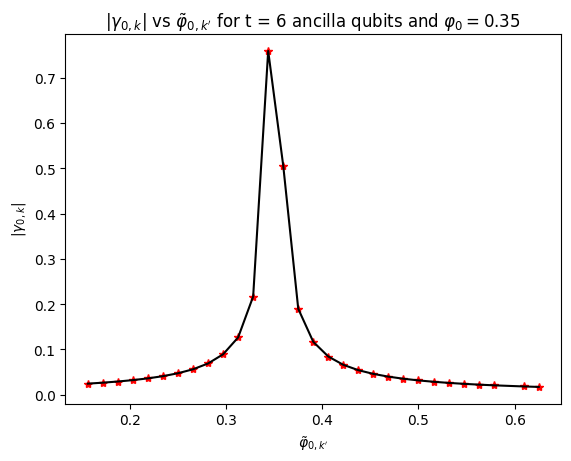

In [45]:
# run code with 6 ancillas
gamma = 1/((2**(ancilla_bits + 1))*abs(angle - kvals))
gamma = gamma/(np.sqrt(sum(gamma**2))) # calculate |gamma_0,k'| function
plt.plot(kvals[10:40], gamma[10:40], 'r*')
plt.plot(kvals[10:40], gamma[10:40], 'k-')
plt.xlabel("$\u03c6\u0303_{0,k'}$")
plt.ylabel('$|\u03B3_{0,k}|$')
plt.title("$|\u03B3_{0,k}|$ vs $\u03c6\u0303_{0,k'}$ for t = 6 ancilla qubits and $\u03c6_0 = 0.35$")
plt.show() # plot function against possible phases

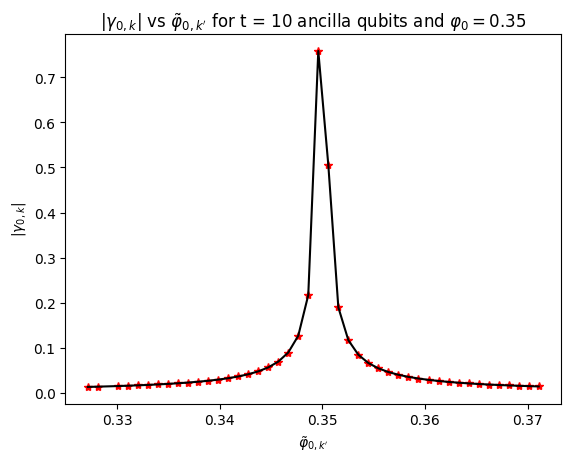

In [40]:
# rerun code above with 10 ancillas and run this cell instead
gamma = 1/((2**(ancilla_bits + 1))*abs(angle - kvals))
gamma = gamma/(np.sqrt(sum(gamma**2))) # calculate |gamma_0,k'| function
plt.plot(kvals[30:75], gamma[30:75], 'r*')
plt.plot(kvals[30:75], gamma[30:75], 'k-')
plt.xlabel("$\u03c6\u0303_{0,k'}$")
plt.ylabel('$|\u03B3_{0,k}|$')
plt.title("$|\u03B3_{0,k}|$ vs $\u03c6\u0303_{0,k'}$ for t = 10 ancilla qubits and $\u03c6_0 = 0.35$")
plt.show() # plot function against possible phases

The binary value of the measurement outcome $k_0'$ can be viewed as some random variable where the probability of obtaining $\tilde{\varphi}_{k_0'}$ that is at least a distance $\epsilon$ away from the expected value $\varphi_0$ is 

$$ P\left(\left|\varphi_0 - \tilde{\varphi}_{k_0'}\right|_1\geq\epsilon\right) = \sum_{\left|\varphi_0 - \tilde{\varphi}_{k'}\right|\geq\epsilon}\left|\gamma_{0,k'}\right|^2 \leq \left|\frac{1}{2^{t+1}\left|\varphi_0 -\tilde{\varphi}_{k'}\right|_1}\right|^2 =  \frac{1}{4T^2\left|\varphi_0 -\tilde{\varphi}_{k'}\right|^2_1}$$

where $T = 2^t$. In other words, this expression represents the probability that the estimated phase is not within the desired error. By setting the random variable $x^2 = \left|\varphi_0 - \tilde{\varphi}_{k'}\right|^2_1$, this sum can be rewritten as

$$ = \sum_{|x|\geq\epsilon}\frac{1}{4T^2x^2} =: \sum_{|x|\geq\epsilon} f(x)$$

In order to understand what this means, we can plot the sum $f(x)$. Since we are looking for $\epsilon = 2^{-d}$, when $d=5$ $f(x)$ can be visualized in the following way.

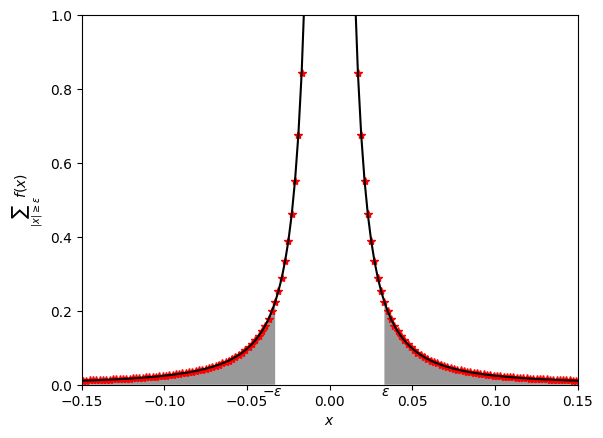

In [47]:
def sum(x):
    sum = 1/(4*(T**2)*(x**2))
    return sum

d = 5
T = 2**d
eps = 1/(2**d)

x = np.linspace(-1,1,1000)
dx1 = x[x >= eps]
dx2 = x[x <= -eps]

func = sum(x)

plt.plot(x, func, 'r*')
plt.plot(x, func, 'k-')

plt.fill_between(dx1, sum(dx1), facecolor='k', alpha=0.4)
plt.fill_between(dx2, sum(dx2), facecolor='k', alpha=0.4)

plt.text(eps,-0.03,'$\epsilon$')
plt.text(-eps-0.01,-0.03,'$-\epsilon$')

plt.xlabel('$x$')
plt.ylabel('$\sum_{|x|\geq \epsilon} f(x)$')
plt.title('')

plt.ylim(0, 1)
plt.xlim(-0.15, 0.15)
plt.show()

By splitting the sum into two sums for $\pm \epsilon$, we get

$$\sum_{|x|\geq\epsilon}\frac{1}{4T^2x^2} = \sum_{x\leq -\epsilon}\frac{1}{4T^2x^2} + \sum_{x\geq\epsilon}\frac{1}{4T^2x^2}$$

and since the sum is the same for both $\pm \epsilon$, we can add them to obtain

$$\sum_{|x|\geq\epsilon}\frac{2}{4T^2x^2} = \sum_{x\geq\epsilon}\frac{1}{2T^2x^2}$$

We can see from the plot and our last expression that this sum is essentially taking the integral from $\epsilon$ onwards. Therefore, looking at just the random variable $x$ we can approximate this sum with the integral

$$\sum_{x\geq\epsilon}\frac{1}{x^2} \leq \int_\epsilon^\infty \frac{1}{x^2} = \frac{1}{\epsilon}$$

Plugging this back in to the original sum we are able to obtain

$$\sum_{|x|\geq\epsilon}\frac{1}{4T^2x^2} \leq \frac{1}{2T^2}\frac{1}{\epsilon}$$

Since a lower degree denominator that is $\geq 1$ means a larger value and $T\geq1$, we can make the coefficient the same degree as $\epsilon$ and say that

$$\frac{1}{2T^2}\frac{1}{\epsilon} \leq \frac{1}{2T}\frac{1}{\epsilon} = \frac{1}{2T\epsilon}$$

We can then set $t-d = \log_2{(\delta^{-1})}$, because $T\epsilon = 2^{t-d} \Rightarrow \log_2{(T\epsilon)} = t - d$, and therefore $T\epsilon = \delta ^{-1}$. So aiming for a $0<\delta<1$, the failure probability is 

$$ P\left(\left|\varphi_0 - \tilde{\varphi}_{k_0'}\right|_1\geq\epsilon\right) \leq \frac{1}{2T\epsilon} = \frac{\delta}{2} \leq \delta$$

In order to obtain the phase $\varphi_0$ to an accuracy of $\epsilon = \frac{1}{2^t}$ with a success probability of at least $1-\delta$, a total of $t = d + \log_2{(\delta^{-1})}$ ancilla qubits are neccessary to store the phase value. Furthermore, because $T\epsilon = \delta^{-1}$, the run time of the simulation must be $T = (\epsilon\delta)^{-1}$

### Hadamard Test vs. Quantum Phase Estimation Simulation

Now let's compare the error of both of our methods for estimating phase: the Hadamard test and the quantum phase estimation procedure.
It is important to note that for this comparison a simulation of a quantum compuputer is being used as opposed to a real quantum machine.

Choose an angle of $\varphi = 1/3$ which does not have an exact bit representation. The phase $\varphi$ was estimated using both procedures for $20$ total trials. Since the precision of the Hadamard test depends on the number of shots, a logspace array from $10^{3}$ to $10^{7}$ was created with $20$ intervals. The Hadamard test was run for all $20$ trials gathering the monte-carlo error and the run time of each trial.

For the $\text{QPE}$ procedure, the precision depends on the number of ancilla bits. Thus an array from $1$ to $20$ was created for the ancilla bits and the appropriate $\text{QPE}$ circuit was run with the error difference and time recorded.

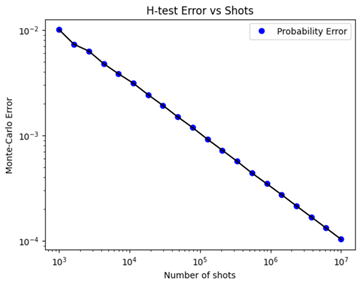 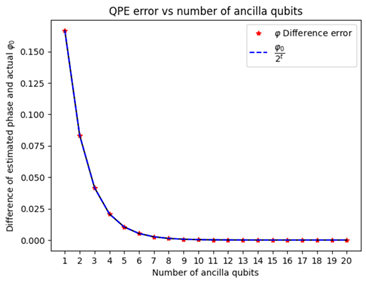

Looking at the error for both the Hadamard test and the QPE procedure, we can see that the $H$-test starts off better, but with the error only decreasing linearly with respect to the number of shots. For QPE, the error with a small number of ancilla qubits is quite high especially compared to the $H$-test, but as the number of these ancilla bits increases, the error drastically decreases exponetially. By plotting these two graphs on the same plot with a log $y$-scale against the trial number on the $x$-axis, it is easier to see which approach is more precise. 

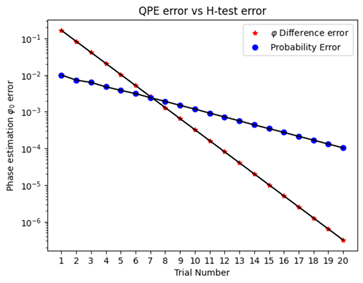

We can see that around trail $7$ they have a very similar error but after this the QPE procedure far surpasses the $H$-test in regards to error. So from this we know that QPE will certainly be more precise for a $\varphi = 1/3$ when the number of ancilla qubits is $7$ or more. But how long does each procedure take? For this simulation the time was measured by marking how long the entire transpilation and running of the circuit takes in python. By plotting the time each trial took for both tests against the trial number, we can observe the relationship in length of time for each trial.

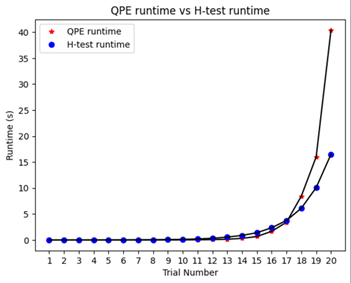

It seems from the graph that both for QPE and the $H$-test about the first $10$ trials do not do much to increase the runtime of the circuit. But as the number of ancilla bits and shots increase the runtime does as well. So to get the best precision without taking a ton of time, we need some sort of sweet spot. In the error graph we can see that for the highest precision we should just use as many ancilla bits as possible in the QPE method as that clearly gives a much better precision. But in the runtime graph we can also see that QPE surpasses the $H$-test at around trial $18$ in runtime. So in this particular case where we have a range of $10^3 - 10^7$ shots for the $H$-test and a range of $1-20$ ancilla qubits for QPE, from these graphs we can see that the optimal estimation of the phase $\varphi = 1/3$ considering both runtime and precision is using the QPE procedure with $17$ ancilla qubits. At $17$ qubits the precision easily surpasses that of the $H$-test but has the same runtime at this trials number. Therefore QPE at $17$ ancillas is the optimal way to estimate this phase of these two methods.

### Hadamard Test vs. Quantum Phase Estimation on Quantum Computer

In theory, from our analysis of these two circuits on the simulation it would seem that the QPE procedure is the best, but does this still hold on a real quantum machine? This time, a phase of $\varphi = 0.25$ was chosen as it has an exact $2$-bit binary representation. This way we should expect to get the exact answer for the QPE procedure when using $2 \leq$ ancilla qubits. For the Hadamard test a range of $10^3 - 10^5$ shots was used in order to save some time but the QPE procedure still goes from $1-20$ ancilla qubits. Performing this on the quantum machine, the following plots were produced to see the error of each method.

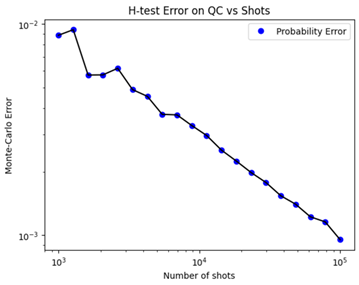 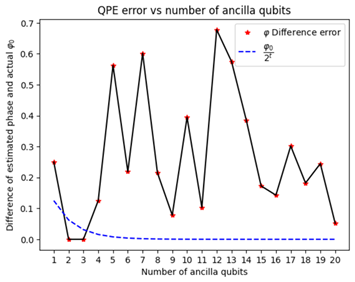

Unfortunately, the error for the QPE procedure looks very bad. On the other hand, the Hadamard test still still looks quite good. The error looks very similar to that in the simulation. It just has a bit more variance and a lower slope than the simulation as there is some noise in the few gates and qubits present in the circuit. Why does the QPE look so bad though? We can see the first three points are what we expect. With just $1$ ancilla qubit, $\varphi$ cannot be exactly represented in binary so there is some expected error which we see. With two or more ancillas $\varphi$ can be exactly represented so there should actually be zero error. With both $2$ and $3$ ancillas we can see this is indeed the case with the error dropping down to zero. But increasing the ancillas more, it then spikes and dips for every trial and is certainly not zero like we expected. This is because we are introducing so many new qubits and gates into the system that it is creating too much noise for our circuit to be effective. To mitigate this noise, Qiskit's built-in circuit optimization is used where we can set the argument "optimization_level" at the transpilation level equal to $0, 1, 2,$ or $3$. Even using optimization_level $=3$, the noise is still gets too strong.

Let's again compare each error plot on a log scale $y$-axis to more easily visualize the difference.

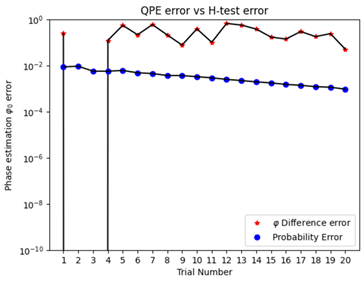

We can again see for $2$ and $3$ ancillas that the error goes all the way down to zero and is clearly superior to the $H$-test in regards to precision. But as the noise takes over with more ancilla qubits, QPE is practically rendered ineffective whereas the $H$-test slowly decreases its error as the number of shots increase. But why does increasing the number of ancilla qubits increase the error so drastically? To analyze this we can look at the depth of our circuit. The depth of some circuit is an integer number representing the number of gates it must execute in its path. A larger depth means there is more room for noise as there are more gates to be executed. When looking at the depth of a circuit it is common to analyze the depth of $2$-qubit gates rather than all gates. Of course a single qubit gate has some intrinsic noise that will affect the system, but $2$-qubit gates that require "talking" between qubits are the main source of noise. By plotting the $2$-qubit depth as the number of ancilla qubits increases, we can see how adding more ancillas effects the depth and thus the noise. 

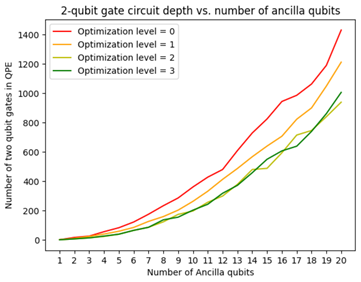

In this plot we can clearly see how the $2$-qubit gate depth of the circuit exponentially increases with respect to the number of ancilla qubits for every optimization level. Even so, the second and third optimization levels are better than with no or just one level of optimization with the third level generally mitigating the most noise. Thus it is still a good idea to optimize the circuit even with its little improvement.

But how does the time compare between each method on a real quantum machine as opposed to the simulation? The time was measured using the implemented time measurement of a circuit in Qiskit's output result where it gives the time in seconds a circuit takes to run on the quantum computer. We then plot the time each trial takes for both methods. 

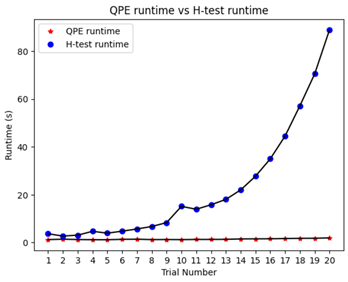

We can see that similar to the simulation the $H$-test increases exponentially with the number of shots. But QPE actually has a very low runtime for every circuit from $1$ all the way to $20$ ancillas. So although in this case for anything above $3$ ancillas the QPE method doesn't effectively work, it is still always much faster than the $H$-test. Therefore, if the noise can somehow be mitigated better as the ancillas qubits increase such that the circuit still gives the correct bit most likely, the QPE algorithm will become extremely effective and easily surpass the $H$-test.

As we can see with the first few trials, QPE isn't completely useless without this improved noise mitigation. If we know the binary value of the phase being estimated can be represented with some very low $d$-bit binary representation such as $\varphi = 0.25$, we can simply use exactly $d$ bits to get a perfect estimation. But until noise can be better handled, any value with a larger or infinite bit binary representation can only be estimated to a very low bit approximation of the value.